In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio numpy matplotlib

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set up directories
base_dir = "/content/traffic_imputation"
data_dir = os.path.join(base_dir, "data")  # Directory for datasets
output_dir = os.path.join(base_dir, "outputs")  # Directory for results

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")


Data directory: /content/traffic_imputation/data
Output directory: /content/traffic_imputation/outputs


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Verify the base path
base_path = "/content/drive/My Drive/deeploycv"
print(f"Base path exists: {os.path.exists(base_path)}")


Mounted at /content/drive
Base path exists: True


In [ ]:
import os
import numpy as np

# Paths
output_folder = "/content/drive/My Drive/deeploycv/output"

# Verify if the output folder exists
if os.path.exists(output_folder):
    print(f"Output folder found: {output_folder}")
    # List all files in the folder
    files = os.listdir(output_folder)
    print(f"Files in output folder: {files}")
else:
    print("Output folder does not exist. Please check the path.")


Output folder found: /content/drive/My Drive/deeploycv/output
Files in output folder: ['cctv052x2004080519x01681_vehicle_counts.json', 'cctv052x2004080519x01681_gasf_matrix.npy', 'cctv052x2004080519x01681_gasf_matrix.png', 'cctv052x2004080517x01662_vehicle_counts.json', 'cctv052x2004080517x01662_gasf_matrix.npy', 'cctv052x2004080517x01662_gasf_matrix.png', 'cctv052x2004080518x01675_vehicle_counts.json', 'cctv052x2004080518x01675_gasf_matrix.npy', 'cctv052x2004080518x01675_gasf_matrix.png', 'cctv052x2004080518x01667_vehicle_counts.json', 'cctv052x2004080518x01667_gasf_matrix.npy', 'cctv052x2004080518x01667_gasf_matrix.png', 'cctv052x2004080518x01666_vehicle_counts.json', 'cctv052x2004080518x01666_gasf_matrix.npy', 'cctv052x2004080518x01666_gasf_matrix.png', 'cctv052x2004080517x01652_vehicle_counts.json', 'cctv052x2004080517x01652_gasf_matrix.npy', 'cctv052x2004080517x01652_gasf_matrix.png', 'cctv052x2004080517x01658_vehicle_counts.json', 'cctv052x2004080517x01658_gasf_matrix.npy', 'cctv

In [ ]:
# Filter GASF matrix files
gasf_files = [f for f in os.listdir(output_folder) if f.endswith('_gasf_matrix.npy')]

# Load a sample GASF matrix
if gasf_files:
    sample_gasf_path = os.path.join(output_folder, gasf_files[0])
    gasf_matrix = np.load(sample_gasf_path)

    print(f"Loaded GASF matrix from: {sample_gasf_path}")
    print(f"GASF Matrix shape: {gasf_matrix.shape}")

    # Display the first few values of the matrix for verification
    print("Sample of GASF matrix values:")
    print(gasf_matrix[:5, :5])
else:
    print("No GASF matrices found in the output folder.")


Loaded GASF matrix from: /content/drive/My Drive/deeploycv/output/cctv052x2004080519x01681_gasf_matrix.npy
GASF Matrix shape: (11, 11)
Sample of GASF matrix values:
[[-1.         -0.98974332 -0.95831486 -1.         -0.82065186]
 [-0.98974332 -0.95918369 -0.90766942 -0.98974332 -0.73060207]
 [-0.95831486 -0.90766942 -0.83673474 -0.95831486 -0.62317762]
 [-1.         -0.98974332 -0.95831486 -1.         -0.82065186]
 [-0.82065186 -0.73060207 -0.62317762 -0.82065186 -0.34693896]]


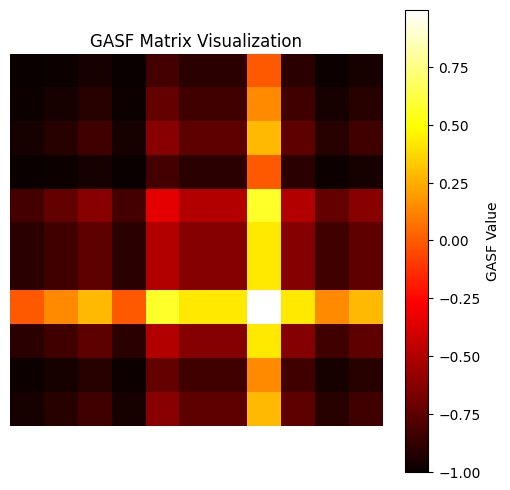

In [ ]:
import matplotlib.pyplot as plt

# Visualize the GASF matrix
plt.figure(figsize=(6, 6))
plt.imshow(gasf_matrix, cmap="hot", interpolation="nearest")
plt.colorbar(label="GASF Value")
plt.title("GASF Matrix Visualization")
plt.axis("off")  # Hide axes for better visual clarity
plt.show()



Batch 1
Masked Matrices Shape: torch.Size([8, 1, 12, 12])
Masks Shape: torch.Size([8, 1, 12, 12])
Original Matrices Shape: torch.Size([8, 1, 12, 12])


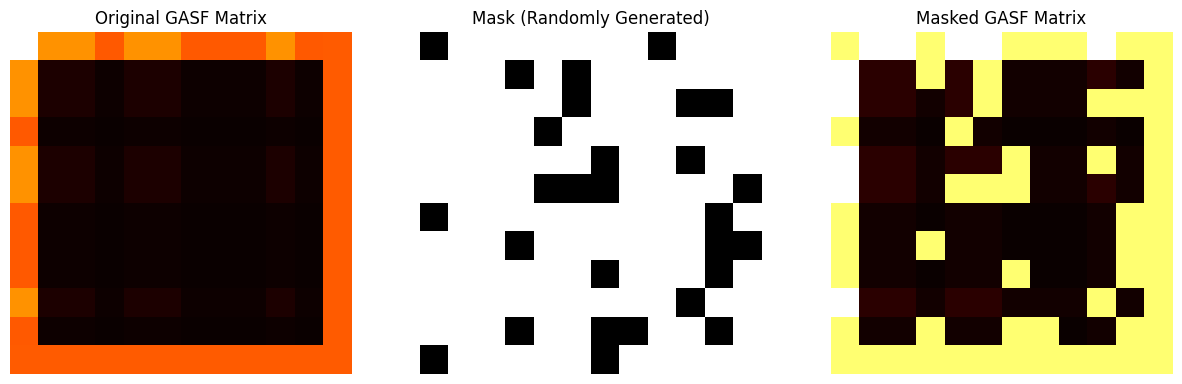

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to Apply Mask
def apply_mask(matrix, mask_ratio=0.2):
    """
    Apply a random mask to the GASF matrix.
    Args:
        matrix (torch.Tensor): The GASF matrix of shape (H, W).
        mask_ratio (float): Fraction of the matrix to mask (values set to 0).
    Returns:
        masked_matrix (torch.Tensor): Matrix with missing regions.
        mask (torch.Tensor): Binary mask (1 = observed, 0 = missing).
    """
    matrix_size = matrix.shape[0]
    mask = torch.ones_like(matrix)
    num_masked = int(mask_ratio * matrix_size * matrix_size)

    # Randomly select indices to mask
    masked_indices = torch.randperm(matrix_size * matrix_size)[:num_masked]
    mask.view(-1)[masked_indices] = 0

    # Apply the mask to the matrix
    masked_matrix = matrix * mask

    return masked_matrix, mask

# Enhanced Dataset Class
class GASFDataset(Dataset):
    def __init__(self, gasf_folder, target_size=12, mask_ratio=0.2, normalize_range=(-1, 1)):
        self.gasf_files = [
            os.path.join(gasf_folder, f) for f in os.listdir(gasf_folder) if f.endswith("_gasf_matrix.npy")
        ]
        self.target_size = target_size
        self.mask_ratio = mask_ratio
        self.normalize_range = normalize_range  # Tuple (min_val, max_val)

    def __len__(self):
        return len(self.gasf_files)

    def __getitem__(self, idx):
        # Load the GASF matrix
        gasf_matrix = np.load(self.gasf_files[idx])
        gasf_matrix = torch.tensor(gasf_matrix, dtype=torch.float32)

        # Normalize the matrix to the specified range
        min_val, max_val = self.normalize_range
        gasf_matrix = (max_val - min_val) * (gasf_matrix - gasf_matrix.min()) / (
            gasf_matrix.max() - gasf_matrix.min() + 1e-6
        ) + min_val

        # Resize or pad the matrix to the target size
        gasf_matrix = F.pad(
            gasf_matrix,
            pad=(0, self.target_size - gasf_matrix.shape[1], 0, self.target_size - gasf_matrix.shape[0]),
            mode="constant",
            value=0,
        )

        # Apply masking
        masked_matrix, mask = apply_mask(gasf_matrix, mask_ratio=self.mask_ratio)

        return masked_matrix.unsqueeze(0), mask.unsqueeze(0), gasf_matrix.unsqueeze(0)


# Define Output Folder
output_folder = "/content/drive/My Drive/deeploycv/output"  # Update your path as needed
if not os.path.exists(output_folder):
    raise ValueError("Output folder does not exist. Please provide the correct path.")

# Initialize Dataset and DataLoader
gasf_dataset = GASFDataset(output_folder, target_size=12, mask_ratio=0.2, normalize_range=(-1, 1))
gasf_loader = DataLoader(gasf_dataset, batch_size=8, shuffle=True, drop_last=True)


# Verify the DataLoader and Visualize
for batch_idx, (masked_matrices, masks, original_matrices) in enumerate(gasf_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Masked Matrices Shape: {masked_matrices.shape}")
    print(f"Masks Shape: {masks.shape}")
    print(f"Original Matrices Shape: {original_matrices.shape}")

    # Visualize one sample
    sample_idx = 0
    masked_matrix = masked_matrices[sample_idx].squeeze(0).numpy()
    mask = masks[sample_idx].squeeze(0).numpy()
    original_matrix = original_matrices[sample_idx].squeeze(0).numpy()

    # Plot original, mask, and masked matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_matrix, cmap="hot")
    plt.title("Original GASF Matrix")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask (Randomly Generated)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(masked_matrix, cmap="hot")
    plt.title("Masked GASF Matrix")
    plt.axis("off")

    plt.show()
    break  # Only visualize one batch


In [ ]:
import torch.nn as nn

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_channels=2, matrix_size=12):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),  # Input: [batch, 2, 12, 12]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),  # Output: [batch, 1, 12, 12]
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, matrix_size=12):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (matrix_size // 4) * (matrix_size // 4), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Check if GPU is available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Initialize models, optimizers, and loss functions
generator = Generator(matrix_size=12).to(device)
discriminator = Discriminator(matrix_size=12).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()


Epoch [1/100], Step [0/31], D Loss: 0.6931, G Loss: 1.0179, Recon Loss: 0.2757
Epoch [1/100], Step [10/31], D Loss: 0.6030, G Loss: 0.9756, Recon Loss: 0.0985
Epoch [1/100], Step [20/31], D Loss: 0.6782, G Loss: 0.8771, Recon Loss: 0.0784
Epoch [1/100], Step [30/31], D Loss: 0.6728, G Loss: 0.8649, Recon Loss: 0.0848
Epoch [2/100], Step [0/31], D Loss: 0.6504, G Loss: 0.9030, Recon Loss: 0.0852
Epoch [2/100], Step [10/31], D Loss: 0.6496, G Loss: 0.9528, Recon Loss: 0.0741
Epoch [2/100], Step [20/31], D Loss: 0.6524, G Loss: 0.9523, Recon Loss: 0.0817
Epoch [2/100], Step [30/31], D Loss: 0.6619, G Loss: 0.9285, Recon Loss: 0.0908
Epoch [3/100], Step [0/31], D Loss: 0.6173, G Loss: 0.9187, Recon Loss: 0.0843
Epoch [3/100], Step [10/31], D Loss: 0.6258, G Loss: 0.8549, Recon Loss: 0.0791
Epoch [3/100], Step [20/31], D Loss: 0.6591, G Loss: 0.8486, Recon Loss: 0.0715
Epoch [3/100], Step [30/31], D Loss: 0.6872, G Loss: 0.7831, Recon Loss: 0.0647
Epoch [4/100], Step [0/31], D Loss: 0.7004,

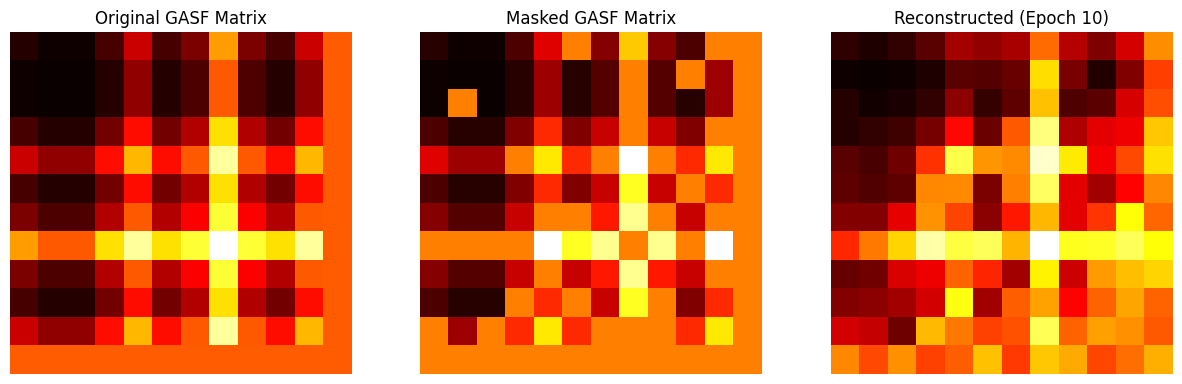

Epoch [11/100], Step [0/31], D Loss: 0.6627, G Loss: 0.7488, Recon Loss: 0.0193
Epoch [11/100], Step [10/31], D Loss: 0.6694, G Loss: 0.7574, Recon Loss: 0.0271
Epoch [11/100], Step [20/31], D Loss: 0.6518, G Loss: 0.8132, Recon Loss: 0.0282
Epoch [11/100], Step [30/31], D Loss: 0.6497, G Loss: 0.7693, Recon Loss: 0.0231
Epoch [12/100], Step [0/31], D Loss: 0.6604, G Loss: 0.7512, Recon Loss: 0.0191
Epoch [12/100], Step [10/31], D Loss: 0.6467, G Loss: 0.7600, Recon Loss: 0.0161
Epoch [12/100], Step [20/31], D Loss: 0.6564, G Loss: 0.6904, Recon Loss: 0.0192
Epoch [12/100], Step [30/31], D Loss: 0.6631, G Loss: 0.7123, Recon Loss: 0.0196
Epoch [13/100], Step [0/31], D Loss: 0.6675, G Loss: 0.6860, Recon Loss: 0.0162
Epoch [13/100], Step [10/31], D Loss: 0.6491, G Loss: 0.7471, Recon Loss: 0.0140
Epoch [13/100], Step [20/31], D Loss: 0.6492, G Loss: 0.8032, Recon Loss: 0.0168
Epoch [13/100], Step [30/31], D Loss: 0.6598, G Loss: 0.7442, Recon Loss: 0.0196
Epoch [14/100], Step [0/31], D 

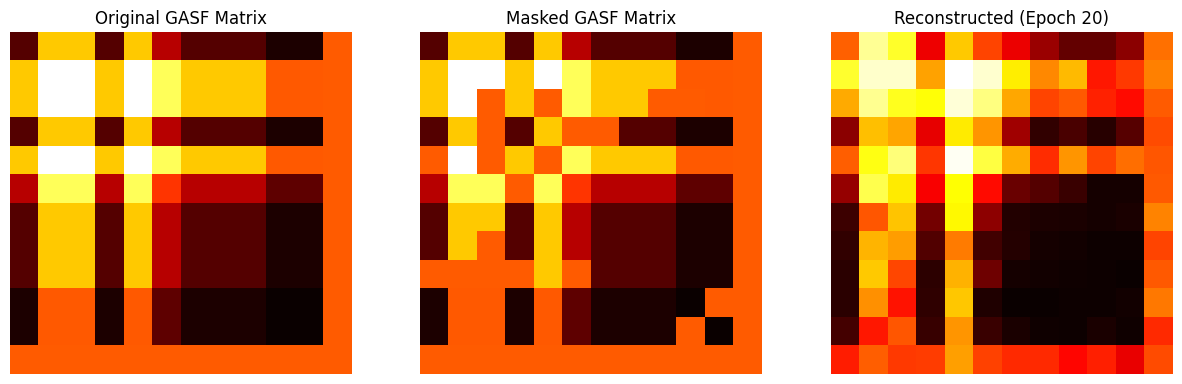

Epoch [21/100], Step [0/31], D Loss: 0.6677, G Loss: 0.7378, Recon Loss: 0.0118
Epoch [21/100], Step [10/31], D Loss: 0.6439, G Loss: 0.7747, Recon Loss: 0.0134
Epoch [21/100], Step [20/31], D Loss: 0.6491, G Loss: 0.7576, Recon Loss: 0.0143
Epoch [21/100], Step [30/31], D Loss: 0.6466, G Loss: 0.7673, Recon Loss: 0.0074
Epoch [22/100], Step [0/31], D Loss: 0.6535, G Loss: 0.7467, Recon Loss: 0.0072
Epoch [22/100], Step [10/31], D Loss: 0.6454, G Loss: 0.8108, Recon Loss: 0.0110
Epoch [22/100], Step [20/31], D Loss: 0.6420, G Loss: 0.7521, Recon Loss: 0.0088
Epoch [22/100], Step [30/31], D Loss: 0.6529, G Loss: 0.6809, Recon Loss: 0.0095
Epoch [23/100], Step [0/31], D Loss: 0.6400, G Loss: 0.7710, Recon Loss: 0.0117
Epoch [23/100], Step [10/31], D Loss: 0.6505, G Loss: 0.7549, Recon Loss: 0.0113
Epoch [23/100], Step [20/31], D Loss: 0.6340, G Loss: 0.7069, Recon Loss: 0.0074
Epoch [23/100], Step [30/31], D Loss: 0.6580, G Loss: 0.7344, Recon Loss: 0.0085
Epoch [24/100], Step [0/31], D 

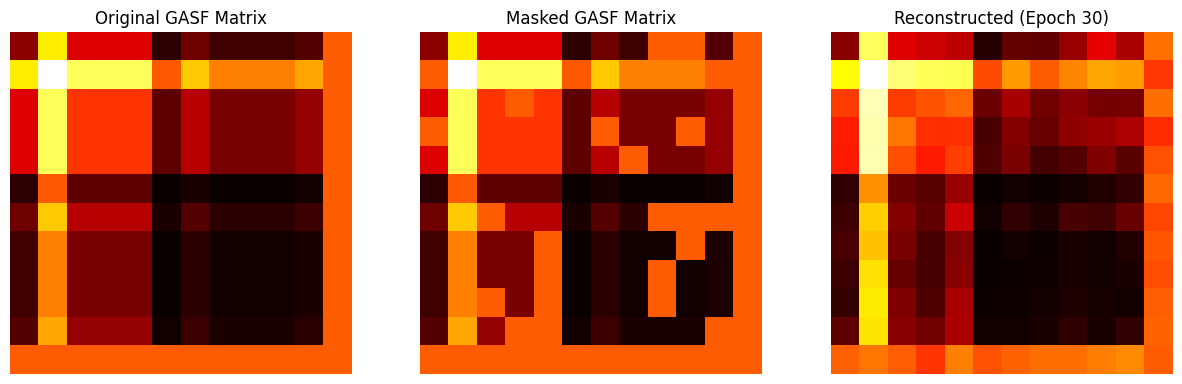

Epoch [31/100], Step [0/31], D Loss: 0.6297, G Loss: 0.7751, Recon Loss: 0.0084
Epoch [31/100], Step [10/31], D Loss: 0.6453, G Loss: 0.8097, Recon Loss: 0.0085
Epoch [31/100], Step [20/31], D Loss: 0.6357, G Loss: 0.7569, Recon Loss: 0.0085
Epoch [31/100], Step [30/31], D Loss: 0.6235, G Loss: 0.7468, Recon Loss: 0.0042
Epoch [32/100], Step [0/31], D Loss: 0.6328, G Loss: 0.7144, Recon Loss: 0.0125
Epoch [32/100], Step [10/31], D Loss: 0.6413, G Loss: 0.8242, Recon Loss: 0.0133
Epoch [32/100], Step [20/31], D Loss: 0.6477, G Loss: 0.8021, Recon Loss: 0.0045
Epoch [32/100], Step [30/31], D Loss: 0.6255, G Loss: 0.8016, Recon Loss: 0.0085
Epoch [33/100], Step [0/31], D Loss: 0.6202, G Loss: 0.7576, Recon Loss: 0.0062
Epoch [33/100], Step [10/31], D Loss: 0.6207, G Loss: 0.7774, Recon Loss: 0.0083
Epoch [33/100], Step [20/31], D Loss: 0.6217, G Loss: 0.8878, Recon Loss: 0.0084
Epoch [33/100], Step [30/31], D Loss: 0.6128, G Loss: 0.7650, Recon Loss: 0.0093
Epoch [34/100], Step [0/31], D 

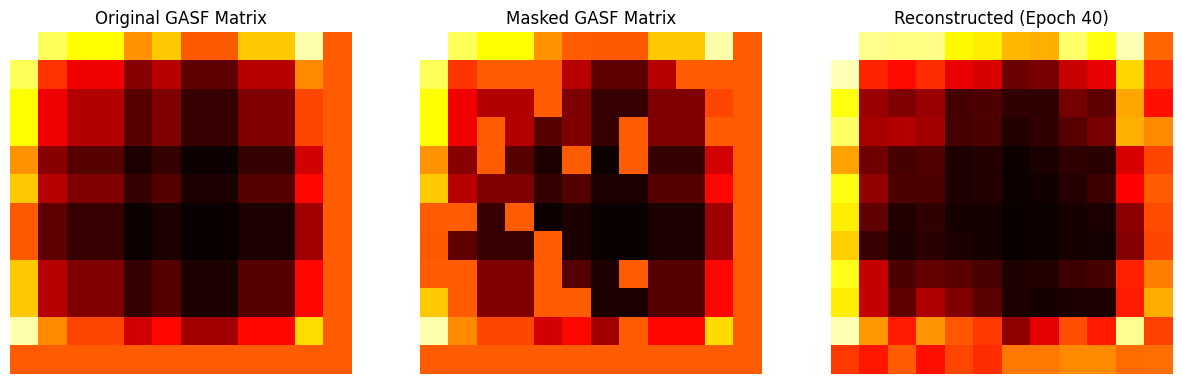

Epoch [41/100], Step [0/31], D Loss: 0.5856, G Loss: 0.8745, Recon Loss: 0.0088
Epoch [41/100], Step [10/31], D Loss: 0.6213, G Loss: 0.7308, Recon Loss: 0.0068
Epoch [41/100], Step [20/31], D Loss: 0.6088, G Loss: 0.8505, Recon Loss: 0.0076
Epoch [41/100], Step [30/31], D Loss: 0.6062, G Loss: 0.8206, Recon Loss: 0.0069
Epoch [42/100], Step [0/31], D Loss: 0.5925, G Loss: 0.8919, Recon Loss: 0.0114
Epoch [42/100], Step [10/31], D Loss: 0.6105, G Loss: 0.8787, Recon Loss: 0.0066
Epoch [42/100], Step [20/31], D Loss: 0.6021, G Loss: 0.7968, Recon Loss: 0.0071
Epoch [42/100], Step [30/31], D Loss: 0.5977, G Loss: 0.6902, Recon Loss: 0.0064
Epoch [43/100], Step [0/31], D Loss: 0.5971, G Loss: 0.8283, Recon Loss: 0.0059
Epoch [43/100], Step [10/31], D Loss: 0.5842, G Loss: 0.9526, Recon Loss: 0.0059
Epoch [43/100], Step [20/31], D Loss: 0.5920, G Loss: 0.8148, Recon Loss: 0.0057
Epoch [43/100], Step [30/31], D Loss: 0.5699, G Loss: 1.0072, Recon Loss: 0.0096
Epoch [44/100], Step [0/31], D 

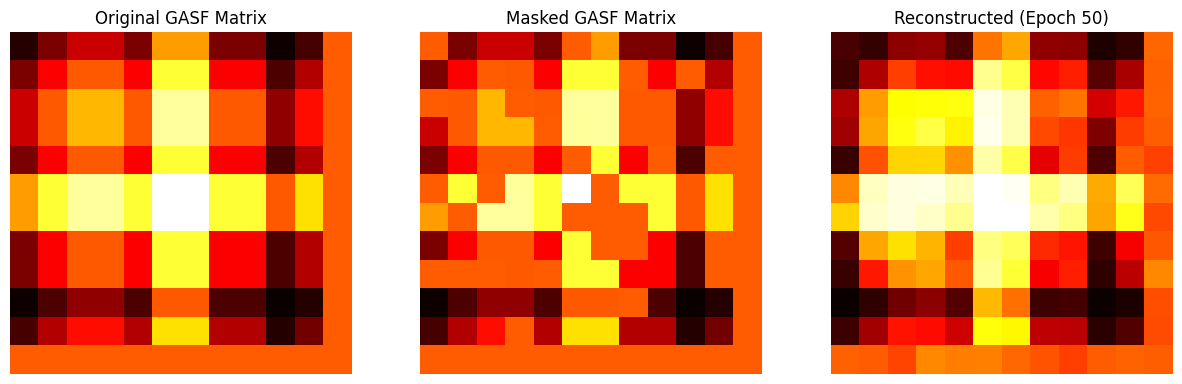

Epoch [51/100], Step [0/31], D Loss: 0.5905, G Loss: 0.9643, Recon Loss: 0.0053
Epoch [51/100], Step [10/31], D Loss: 0.5646, G Loss: 0.8157, Recon Loss: 0.0038
Epoch [51/100], Step [20/31], D Loss: 0.6265, G Loss: 0.7299, Recon Loss: 0.0039
Epoch [51/100], Step [30/31], D Loss: 0.5710, G Loss: 0.8145, Recon Loss: 0.0035
Epoch [52/100], Step [0/31], D Loss: 0.5700, G Loss: 1.0268, Recon Loss: 0.0079
Epoch [52/100], Step [10/31], D Loss: 0.5825, G Loss: 0.7607, Recon Loss: 0.0063
Epoch [52/100], Step [20/31], D Loss: 0.5387, G Loss: 1.0643, Recon Loss: 0.0059
Epoch [52/100], Step [30/31], D Loss: 0.5577, G Loss: 0.8379, Recon Loss: 0.0064
Epoch [53/100], Step [0/31], D Loss: 0.5812, G Loss: 0.8621, Recon Loss: 0.0042
Epoch [53/100], Step [10/31], D Loss: 0.5692, G Loss: 0.7874, Recon Loss: 0.0086
Epoch [53/100], Step [20/31], D Loss: 0.5570, G Loss: 0.8014, Recon Loss: 0.0052
Epoch [53/100], Step [30/31], D Loss: 0.5571, G Loss: 0.9662, Recon Loss: 0.0048
Epoch [54/100], Step [0/31], D 

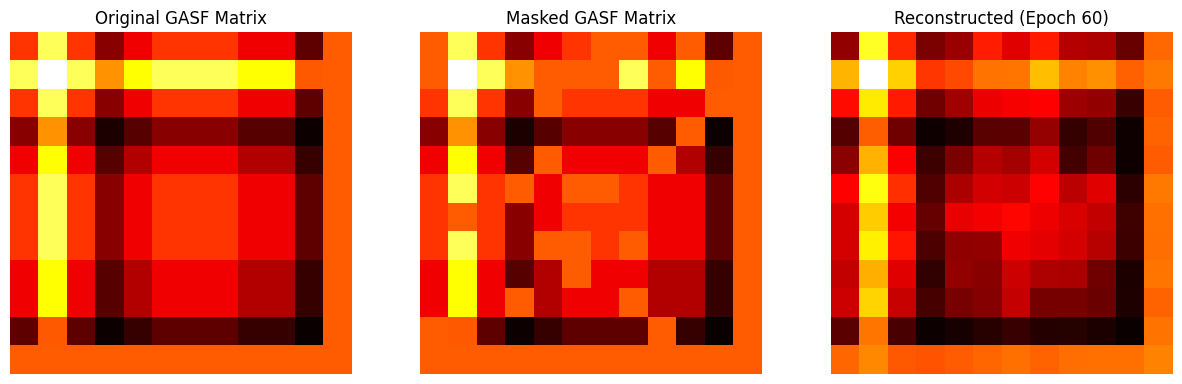

Epoch [61/100], Step [0/31], D Loss: 0.5686, G Loss: 0.8096, Recon Loss: 0.0049
Epoch [61/100], Step [10/31], D Loss: 0.5300, G Loss: 0.9912, Recon Loss: 0.0058
Epoch [61/100], Step [20/31], D Loss: 0.4394, G Loss: 1.0650, Recon Loss: 0.0246
Epoch [61/100], Step [30/31], D Loss: 0.5435, G Loss: 0.9230, Recon Loss: 0.0052
Epoch [62/100], Step [0/31], D Loss: 0.5487, G Loss: 0.8449, Recon Loss: 0.0048
Epoch [62/100], Step [10/31], D Loss: 0.4500, G Loss: 1.1763, Recon Loss: 0.0221
Epoch [62/100], Step [20/31], D Loss: 0.6206, G Loss: 0.7882, Recon Loss: 0.0056
Epoch [62/100], Step [30/31], D Loss: 0.5218, G Loss: 0.9531, Recon Loss: 0.0065
Epoch [63/100], Step [0/31], D Loss: 0.5333, G Loss: 0.9830, Recon Loss: 0.0064
Epoch [63/100], Step [10/31], D Loss: 0.5581, G Loss: 0.8300, Recon Loss: 0.0052
Epoch [63/100], Step [20/31], D Loss: 0.5468, G Loss: 0.8800, Recon Loss: 0.0075
Epoch [63/100], Step [30/31], D Loss: 0.5563, G Loss: 0.7761, Recon Loss: 0.0055
Epoch [64/100], Step [0/31], D 

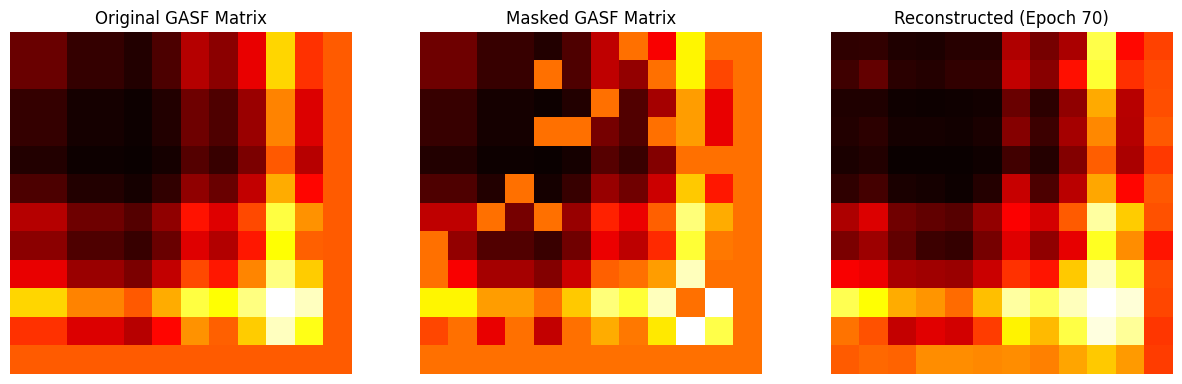

Epoch [71/100], Step [0/31], D Loss: 0.4994, G Loss: 1.0905, Recon Loss: 0.0063
Epoch [71/100], Step [10/31], D Loss: 0.4729, G Loss: 1.1574, Recon Loss: 0.0077
Epoch [71/100], Step [20/31], D Loss: 0.5017, G Loss: 1.0137, Recon Loss: 0.0069
Epoch [71/100], Step [30/31], D Loss: 0.5234, G Loss: 0.8077, Recon Loss: 0.0040
Epoch [72/100], Step [0/31], D Loss: 0.5364, G Loss: 1.2346, Recon Loss: 0.0049
Epoch [72/100], Step [10/31], D Loss: 0.4907, G Loss: 1.1452, Recon Loss: 0.0102
Epoch [72/100], Step [20/31], D Loss: 0.5022, G Loss: 1.0986, Recon Loss: 0.0079
Epoch [72/100], Step [30/31], D Loss: 0.4589, G Loss: 1.0801, Recon Loss: 0.0050
Epoch [73/100], Step [0/31], D Loss: 0.4398, G Loss: 1.2168, Recon Loss: 0.0056
Epoch [73/100], Step [10/31], D Loss: 0.4594, G Loss: 1.2662, Recon Loss: 0.0061
Epoch [73/100], Step [20/31], D Loss: 0.4728, G Loss: 1.1125, Recon Loss: 0.0087
Epoch [73/100], Step [30/31], D Loss: 0.4486, G Loss: 1.0062, Recon Loss: 0.0115
Epoch [74/100], Step [0/31], D 

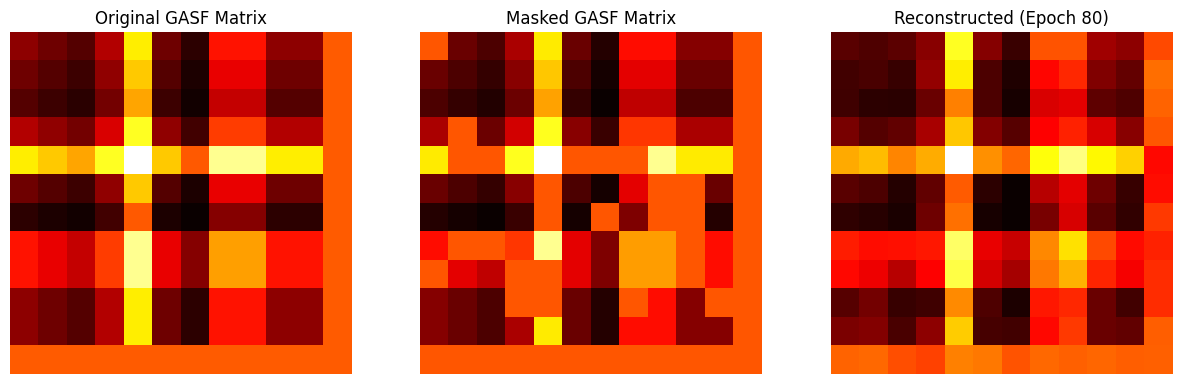

Epoch [81/100], Step [0/31], D Loss: 0.4090, G Loss: 1.2836, Recon Loss: 0.0065
Epoch [81/100], Step [10/31], D Loss: 0.4271, G Loss: 1.1298, Recon Loss: 0.0073
Epoch [81/100], Step [20/31], D Loss: 0.4953, G Loss: 1.1405, Recon Loss: 0.0041
Epoch [81/100], Step [30/31], D Loss: 0.4192, G Loss: 1.3776, Recon Loss: 0.0073
Epoch [82/100], Step [0/31], D Loss: 0.4998, G Loss: 0.9802, Recon Loss: 0.0030
Epoch [82/100], Step [10/31], D Loss: 0.4763, G Loss: 1.0368, Recon Loss: 0.0057
Epoch [82/100], Step [20/31], D Loss: 0.4210, G Loss: 1.3689, Recon Loss: 0.0094
Epoch [82/100], Step [30/31], D Loss: 0.4129, G Loss: 1.1581, Recon Loss: 0.0057
Epoch [83/100], Step [0/31], D Loss: 0.4277, G Loss: 1.4110, Recon Loss: 0.0050
Epoch [83/100], Step [10/31], D Loss: 0.4673, G Loss: 1.0017, Recon Loss: 0.0049
Epoch [83/100], Step [20/31], D Loss: 0.4504, G Loss: 1.1361, Recon Loss: 0.0045
Epoch [83/100], Step [30/31], D Loss: 0.4505, G Loss: 0.8555, Recon Loss: 0.0035
Epoch [84/100], Step [0/31], D 

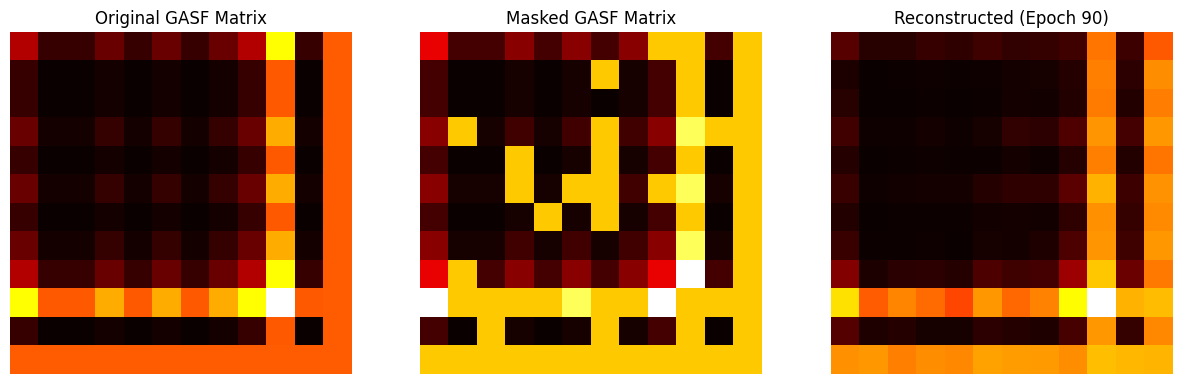

Epoch [91/100], Step [0/31], D Loss: 0.4390, G Loss: 1.2934, Recon Loss: 0.0045
Epoch [91/100], Step [10/31], D Loss: 0.4871, G Loss: 0.9949, Recon Loss: 0.0038
Epoch [91/100], Step [20/31], D Loss: 0.3960, G Loss: 1.2338, Recon Loss: 0.0034
Epoch [91/100], Step [30/31], D Loss: 0.4252, G Loss: 1.2324, Recon Loss: 0.0051
Epoch [92/100], Step [0/31], D Loss: 0.4160, G Loss: 1.0159, Recon Loss: 0.0046
Epoch [92/100], Step [10/31], D Loss: 0.4077, G Loss: 1.1907, Recon Loss: 0.0048
Epoch [92/100], Step [20/31], D Loss: 0.4769, G Loss: 0.9700, Recon Loss: 0.0047
Epoch [92/100], Step [30/31], D Loss: 0.4957, G Loss: 0.9766, Recon Loss: 0.0047
Epoch [93/100], Step [0/31], D Loss: 0.4569, G Loss: 0.9421, Recon Loss: 0.0038
Epoch [93/100], Step [10/31], D Loss: 0.4385, G Loss: 1.1855, Recon Loss: 0.0051
Epoch [93/100], Step [20/31], D Loss: 0.5117, G Loss: 0.9697, Recon Loss: 0.0036
Epoch [93/100], Step [30/31], D Loss: 0.5056, G Loss: 1.1212, Recon Loss: 0.0037
Epoch [94/100], Step [0/31], D 

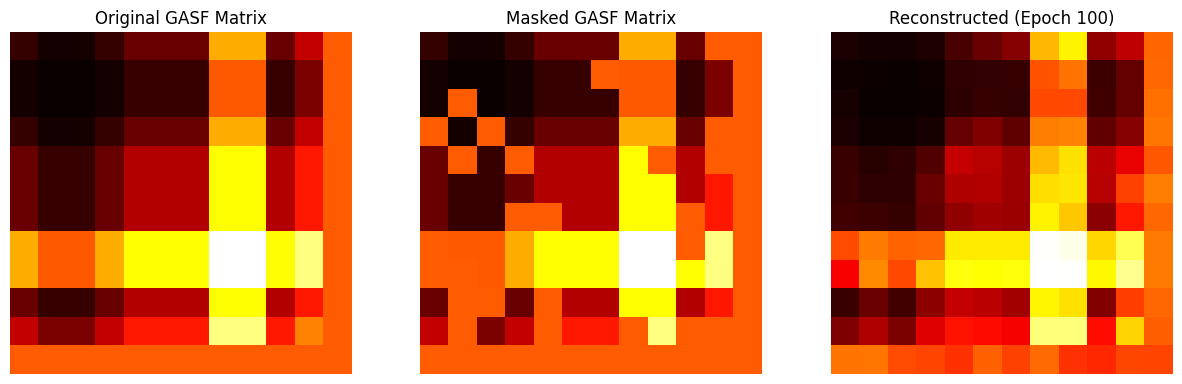

In [ ]:
# GAN Training Loop
num_epochs = 100
latent_dim = 100
log_interval = 10  # Logging frequency
save_interval = 10  # Save/visualize frequency

for epoch in range(num_epochs):
    for i, (masked_matrices, masks, original_matrices) in enumerate(gasf_loader):
        # Move data to the appropriate device
        masked_matrices = masked_matrices.to(device)
        masks = masks.to(device)
        original_matrices = original_matrices.to(device)
        batch_size = masked_matrices.size(0)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real labels for original matrices
        real_labels = torch.ones((batch_size, 1)).to(device)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        # Real loss
        real_loss = adversarial_loss(discriminator(original_matrices), real_labels)

        # Fake loss
        input_for_generator = torch.cat((masked_matrices, masks), dim=1)  # Concatenate masked input and mask
        reconstructed_matrices = generator(input_for_generator)
        fake_loss = adversarial_loss(discriminator(reconstructed_matrices.detach()), fake_labels)

        # Total Discriminator Loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Generator adversarial loss
        g_adv_loss = adversarial_loss(discriminator(reconstructed_matrices), real_labels)

        # Generator reconstruction loss (focuses on masked regions)
        g_recon_loss = reconstruction_loss(
            reconstructed_matrices * (1 - masks), original_matrices * (1 - masks)
        )

        # Total Generator Loss
        g_loss = g_adv_loss + g_recon_loss
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Logging
        if i % log_interval == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(gasf_loader)}], "
                f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, Recon Loss: {g_recon_loss.item():.4f}"
            )

    # ---------------------
    # Save and Visualize Reconstructed Samples
    # ---------------------
    if (epoch + 1) % save_interval == 0:
        with torch.no_grad():
            sample_reconstructed = reconstructed_matrices[0].squeeze().cpu().numpy()
            sample_original = original_matrices[0].squeeze().cpu().numpy()
            sample_masked = masked_matrices[0].squeeze().cpu().numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(sample_original, cmap="hot")
            plt.title("Original GASF Matrix")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(sample_masked, cmap="hot")
            plt.title("Masked GASF Matrix")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(sample_reconstructed, cmap="hot")
            plt.title(f"Reconstructed (Epoch {epoch+1})")
            plt.axis("off")

            plt.show()


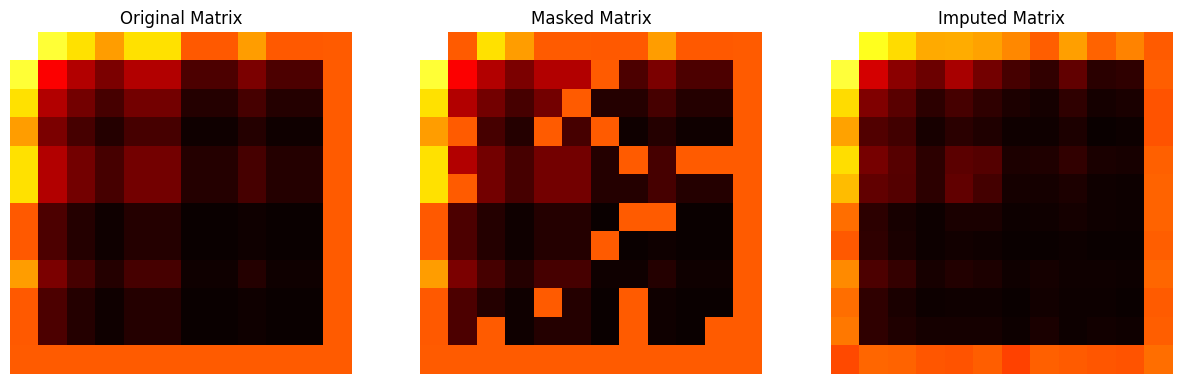

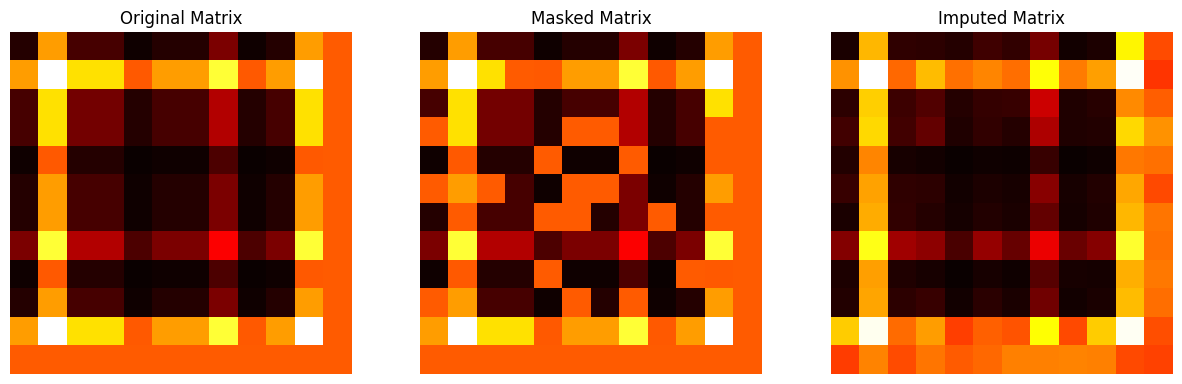

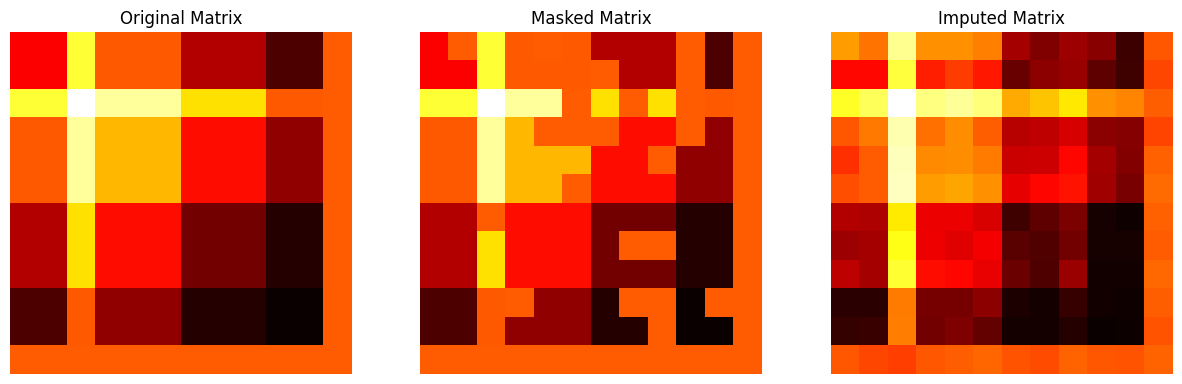

In [ ]:
# Load a batch for evaluation
generator.eval()
masked_matrices, masks, original_matrices = next(iter(gasf_loader))
masked_matrices = masked_matrices.to(device)
masks = masks.to(device)
original_matrices = original_matrices.to(device)

# Generate imputed matrices
with torch.no_grad():
    input_for_generator = torch.cat((masked_matrices, masks), dim=1)  # Concatenate masked input and masks
    imputed_matrices = generator(input_for_generator)

# Visualize Results
for i in range(3):  # Visualize first 3 samples
    original = original_matrices[i].squeeze(0).cpu().numpy()
    masked = masked_matrices[i].squeeze(0).cpu().numpy()
    imputed = imputed_matrices[i].squeeze(0).cpu().numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap="hot")
    plt.title("Original Matrix")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(masked, cmap="hot")
    plt.title("Masked Matrix")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(imputed, cmap="hot")
    plt.title("Imputed Matrix")
    plt.axis("off")

    plt.show()


In [ ]:
# Initialize a counter before training starts
total_synthetic = 0

# Training Loop
for epoch in range(num_epochs):
    for batch_idx, (masked_matrices, masks, original_matrices) in enumerate(gasf_loader):
        # Training logic here (omitted for brevity)

        # Count synthetic matrices
        total_synthetic += masked_matrices.size(0)

    # Logging or visualization per epoch (optional)

# After Training
print(f"Total synthetic matrices generated during training: {total_synthetic}")


Total synthetic matrices generated during training: 24800


In [ ]:
# Set the generator to evaluation mode
generator.eval()

# Initialize accumulators for RMSE and MAE
rmse_accumulator = 0
mae_accumulator = 0
num_batches = 0

# Evaluate over the DataLoader
for batch_idx, (masked_matrices, masks, original_matrices) in enumerate(gasf_loader):
    masked_matrices = masked_matrices.to(device)
    masks = masks.to(device)
    original_matrices = original_matrices.to(device)

    # Generate imputed matrices
    with torch.no_grad():
        input_for_generator = torch.cat((masked_matrices, masks), dim=1)
        imputed_matrices = generator(input_for_generator)

    # Calculate RMSE and MAE for masked regions only
    diff = imputed_matrices - original_matrices
    mse = torch.mean((diff * (1 - masks)) ** 2)  # Mean Squared Error
    mae = torch.mean(torch.abs(diff * (1 - masks)))  # Mean Absolute Error

    rmse_accumulator += torch.sqrt(mse).item()
    mae_accumulator += mae.item()
    num_batches += 1

# Compute average RMSE and MAE
average_rmse = rmse_accumulator / num_batches
average_mae = mae_accumulator / num_batches

print(f"Average RMSE: {average_rmse:.4f}")
print(f"Average MAE: {average_mae:.4f}")


Average RMSE: 0.0626
Average MAE: 0.0194
